In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import influence_plot
from scipy.stats import spearmanr
from sklearn.preprocessing    import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble        import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# ------------------------------------------------------------------------------
# 1) 데이터 로드 및 병합
# ------------------------------------------------------------------------------
file1 = r"E:\safety_sim\data-visualization\code\traffic-flow\자치구별_교통흐름방해.xlsx"
file2 = r"E:\safety_sim\data-visualization\code\traffic-flow\자치구별_주정차단속.xlsx"
file3 = r"E:\safety_sim\data-visualization\code\criminal\자치구별_CCTV수.xlsx"


plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


df_flow    = pd.read_excel(file1)   # '자치구', '범죄유형 합계'
df_parking = pd.read_excel(file2)   # '자치구', '개수'
df_cctv    = pd.read_excel(file3)   # '자치구', 'CCTV수'


In [3]:
# 첫 2행 확인 (선택)
print(df_flow.head(2), df_parking.head(2), df_cctv.head(2), sep='\n\n')


   자치구       범죄유형 합계
0  강남구  20070.857143
1  강동구   7090.428571

   자치구      개수
0  강남구  319427
1  마포구  285247

    자치구  CCTV_수
0   양천구    4795
1  영등포구    4697


In [4]:
# 자치구 기준으로 순차 병합
df = (
    df_flow
    .merge(df_parking, on='자치구', how='inner')
    .merge(df_cctv,    on='자치구', how='left')
)


In [5]:
df.columns.tolist()

['자치구', '범죄유형 합계', '개수', 'CCTV_수']

In [6]:
# 읽기 편하게 이름 변경
df = df.rename(columns={
    '범죄유형 합계': '교통흐름방해합계',
    '개수':         '주정차단속합계',
    'CCTV_수':      'CCTV수'
})

In [7]:
# 2‑1. 중복 제거
df = df.drop_duplicates(subset=['자치구'])

# 2‑2. 필수 컬럼 결측치 제거
df = df.dropna(subset=['주정차단속합계', '교통흐름방해합계'])

# 2‑3. 음수·0 값 제거 (물리적으로 말이 안 되는 경우)
df = df[(df['주정차단속합계'] > 0) & (df['교통흐름방해합계'] > 0)]

# 2‑4. IQR 기반 이상치 제거
for col in ['주정차단속합계', '교통흐름방해합계', 'CCTV수']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df = df[df[col].between(lower, upper)]

# 2‑5. CCTV 결측은 0 처리
df['CCTV수'] = df['CCTV수'].fillna(0)

In [8]:
print(f"클리닝 후 자치구 개수: {len(df)}")

클리닝 후 자치구 개수: 19


In [9]:
# 3) 비모수 상관분석: Spearman
# ------------------------------------------------------------------------------
corr_spear, pval = spearmanr(df['주정차단속합계'], df['교통흐름방해합계'])
print(f"▶ Spearman 상관계수: {corr_spear:.4f} (p={pval:.3g})")


▶ Spearman 상관계수: 0.5684 (p=0.0111)


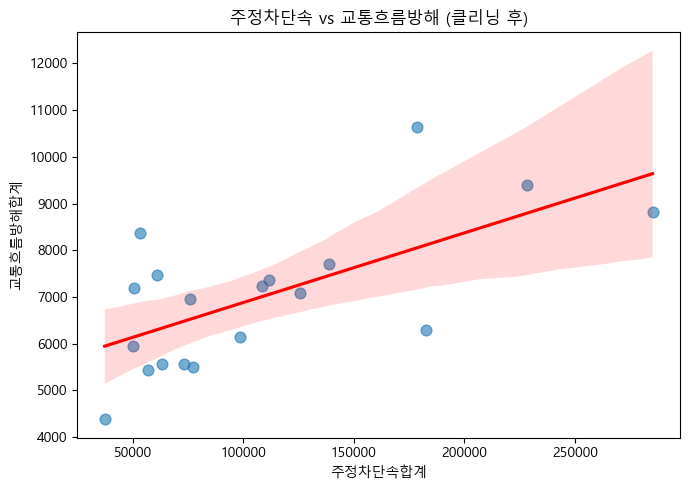

In [10]:
# 4) 산점도 + 회귀선 시각화
# ------------------------------------------------------------------------------
plt.figure(figsize=(7,5))
sns.regplot(
    x='주정차단속합계',
    y='교통흐름방해합계',
    data=df,
    scatter_kws={'s':60, 'alpha':0.6},
    line_kws={'color':'red'}
)
plt.title('주정차단속 vs 교통흐름방해 (클리닝 후)')
plt.xlabel('주정차단속합계')
plt.ylabel('교통흐름방해합계')
plt.tight_layout()
plt.show()

In [11]:
# 5) 회귀분석 준비: 표준화
# ------------------------------------------------------------------------------
features = ['주정차단속합계', 'CCTV수']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
y = df['교통흐름방해합계'].values

In [12]:
# (a) 단일 회귀
X1 = sm.add_constant(X_scaled[:, [0]])
model1 = sm.OLS(y, X1).fit()
print("\n=== 단일 회귀 (주정차단속) ===")
print(model1.summary())

# (b) 다중 회귀
X2 = sm.add_constant(X_scaled)
model2 = sm.OLS(y, X2).fit()
print("\n=== 다중 회귀 (주정차단속 + CCTV) ===")
print(model2.summary())


=== 단일 회귀 (주정차단속) ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     12.56
Date:                Tue, 22 Apr 2025   Prob (F-statistic):            0.00249
Time:                        00:04:50   Log-Likelihood:                -160.74
No. Observations:                  19   AIC:                             325.5
Df Residuals:                      17   BIC:                             327.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7003.4737    277.

e:\Anaconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)
e:\Anaconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


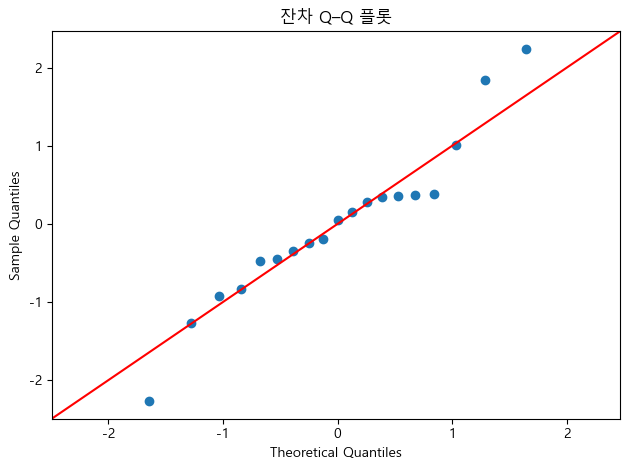

In [13]:
# 6) 잔차 진단
# ------------------------------------------------------------------------------
resid   = model2.resid
fitted  = model2.fittedvalues

# Q–Q 플롯
sm.qqplot(resid, line='45', fit=True)
plt.title('잔차 Q–Q 플롯')
plt.tight_layout()
plt.show()


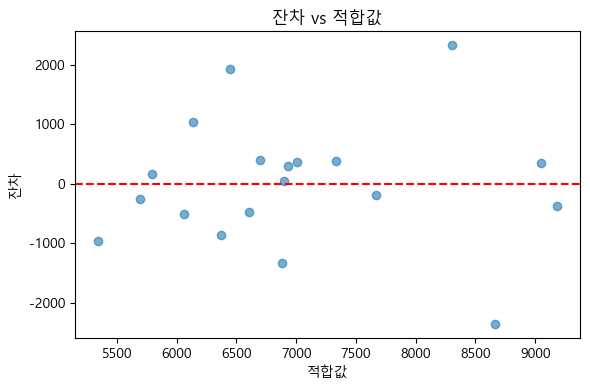

In [14]:
# 잔차 vs 적합값
plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('적합값')
plt.ylabel('잔차')
plt.title('잔차 vs 적합값')
plt.tight_layout()
plt.show()

In [15]:
features = ['주정차단속합계','CCTV수']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
y        = df['교통흐름방해합계'].values

# OLS용 디자인 행렬
X2 = sm.add_constant(X_scaled)

In [16]:
ols = sm.OLS(y, X2).fit()
print("\n=== OLS 회귀 (다중) ===")
print(ols.summary())


=== OLS 회귀 (다중) ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     8.738
Date:                Tue, 22 Apr 2025   Prob (F-statistic):            0.00272
Time:                        00:04:50   Log-Likelihood:                -158.98
No. Observations:                  19   AIC:                             324.0
Df Residuals:                      16   BIC:                             326.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7003.4737    260.39

e:\Anaconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


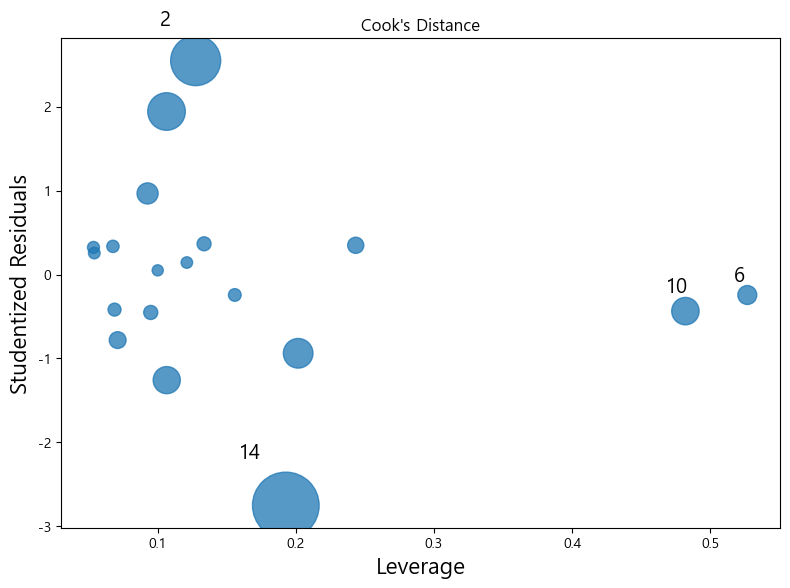

In [17]:
# 5) 영향점 분석 (Cook's distance)
# ------------------------------------------------------------------------------
infl = ols.get_influence()
fig, ax = plt.subplots(figsize=(8,6))
influence_plot(ols, ax=ax, criterion="cooks")
plt.title("Cook's Distance")
plt.tight_layout()
plt.show()

In [18]:
# 6) 로그 변환 회귀
# ------------------------------------------------------------------------------
y_log  = np.log1p(df['교통흐름방해합계'].values)
ols_log = sm.OLS(y_log, X2).fit()
print("\n=== 로그 변환 OLS 회귀 ===")
print(ols_log.summary())


=== 로그 변환 OLS 회귀 ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     8.817
Date:                Tue, 22 Apr 2025   Prob (F-statistic):            0.00262
Time:                        00:04:50   Log-Likelihood:                 9.5328
No. Observations:                  19   AIC:                            -13.07
Df Residuals:                      16   BIC:                            -10.23
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8317      0.0

e:\Anaconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


In [19]:
# 7) 가중 최소제곱 (WLS)
# ------------------------------------------------------------------------------
# studentized residual 사용
std_resid = infl.resid_studentized_external
weights   = 1 / np.abs(std_resid)
wls       = sm.WLS(y, X2, weights=weights).fit()
print("\n=== WLS 회귀 (가중치: 1/|std_resid|) ===")
print(wls.summary())


=== WLS 회귀 (가중치: 1/|std_resid|) ===


e:\Anaconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.791
Model:                            WLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     30.30
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           3.63e-06
Time:                        00:04:50   Log-Likelihood:                -148.87
No. Observations:                  19   AIC:                             303.7
Df Residuals:                      16   BIC:                             306.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7039.2402    123.773     56.872      0.0

In [20]:
# 8) 비선형 모델: RF & GBM 비교
# ------------------------------------------------------------------------------
# Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [21]:
# 5‑fold 교차검증 R²
print("\n=== 교차검증 R² (5‑fold) ===")
for name, m in models.items():
    scores = cross_val_score(m, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")



=== 교차검증 R² (5‑fold) ===
RandomForest: -0.656 ± 1.075
GradientBoosting: -1.076 ± 2.194


In [22]:
# 테스트 세트 성능
print("\n=== Test 세트 성능 ===")
for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    print(f"\n{name}: MAE={mae:.1f}, RMSE={rmse:.1f}, R²={r2:.3f}")


=== Test 세트 성능 ===

RandomForest: MAE=801.8, RMSE=929.1, R²=0.656

GradientBoosting: MAE=832.9, RMSE=950.9, R²=0.640


In [23]:
import pandas as pd, numpy as np, statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 기존 X2, y, df 준비되어 있다고 가정
ols = sm.OLS(y, X2).fit()
inf = OLSInfluence(ols)


In [24]:

# --- 1) 영향점 필터링 ---------------------------------------------------------
cook_cut = 4 / len(df)          # ≈ 0.21
keep_idx = (inf.cooks_distance[0] < cook_cut) & \
           (np.abs(inf.resid_studentized_external) < 2.5)
df_trim  = df.loc[keep_idx].reset_index(drop=True)
print(f"제거된 자치구 수: {len(df) - len(df_trim)}")


제거된 자치구 수: 2


In [25]:
# 재구성
X_scaled_trim = scaler.fit_transform(df_trim[features])
X2_trim       = sm.add_constant(X_scaled_trim)
y_trim        = df_trim['교통흐름방해합계'].values

In [26]:
# --- 2) Robust Linear Model ---------------------------------------------------
rlm = sm.RLM(y_trim, X2_trim, M=sm.robust.norms.HuberT()).fit()
print(rlm.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   17
Model:                            RLM   Df Residuals:                       14
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 22 Apr 2025                                         
Time:                        00:04:54                                         
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6771.6067    173.828     38.956      0.0

In [27]:
# --- 3) RandomForest 하이퍼파라미터 튜닝 --------------------------------------
param_dist = {
    'n_estimators':   range(50, 301, 50),
    'max_depth':      [None, 3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf':  [1, 2, 3]
}

rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(
    rf, param_dist,
    n_iter=30,
    cv=LeaveOneOut(),      # LOOCV로 안정적 검증
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
).fit(X_scaled_trim, y_trim)

print("Best RF params:", search.best_params_)
best_rf = search.best_estimator_

Best RF params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 4}


In [28]:
# --- 4) LOOCV 성능 확인 -------------------------------------------------------
y_pred, y_true = [], []
loo = LeaveOneOut()
for train, test in loo.split(X_scaled_trim):
    best_rf.fit(X_scaled_trim[train], y_trim[train])
    y_pred.append(best_rf.predict(X_scaled_trim[test])[0])
    y_true.append(y_trim[test][0])

rmse = mean_squared_error(y_true, y_pred, squared=False)
r2   = r2_score(y_true, y_pred)
print(f"RF(LOOCV)  RMSE={rmse:.1f},  R²={r2:.3f}")

RF(LOOCV)  RMSE=1043.8,  R²=0.361


e:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [29]:
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.robust.norms import HuberT

# LOOCV 준비
y = df_trim['교통흐름방해합계'].values
X = sm.add_constant(scaler.fit_transform(df_trim[features]))
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
y_pred_rlm, y_true = [], []
for train_idx, test_idx in loo.split(X):
    model = RLM(y[train_idx], X[train_idx], M=HuberT()).fit()
    y_pred_rlm.append(model.predict(X[test_idx])[0])
    y_true.append(y[test_idx][0])

rmse_rlm = mean_squared_error(y_true, y_pred_rlm, squared=False)
r2_rlm   = r2_score(y_true, y_pred_rlm)
print(f"RLM LOOCV → RMSE: {rmse_rlm:.1f},  R²: {r2_rlm:.3f}")


RLM LOOCV → RMSE: 903.9,  R²: 0.520


e:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [30]:
from sklearn.linear_model import TheilSenRegressor, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut

# 1) Theil–Sen Regressor LOOCV
loo = LeaveOneOut()
y_true, y_ts = [], []
ts = TheilSenRegressor(random_state=42)
for tr, te in loo.split(X_scaled_trim):
    ts.fit(X_scaled_trim[tr], y_trim[tr])
    y_ts.append(ts.predict(X_scaled_trim[te])[0])
    y_true.append(y_trim[te][0])

print("Theil–Sen LOOCV →",
      "RMSE:", round(mean_squared_error(y_true, y_ts, squared=False),1),
      "R²:", round(r2_score(y_true, y_ts),3))

Theil–Sen LOOCV → RMSE: 931.4 R²: 0.491


e:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:

# 2) ElasticNetCV LOOCV
en = ElasticNetCV(l1_ratio=[.1, .5, .9], cv=loo, random_state=42)
y_en = en.fit(X_scaled_trim, y_trim).predict(X_scaled_trim)
print("ElasticNetCV in-sample →",
      "RMSE:", round(mean_squared_error(y_trim, y_en, squared=False),1),
      "R²:", round(r2_score(y_trim, y_en),3))

ElasticNetCV in-sample → RMSE: 755.0 R²: 0.665


e:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [32]:
loo = LeaveOneOut()
y_en_pred, y_true = [], []

en = ElasticNetCV(l1_ratio=[.1, .5, .9], cv=loo, random_state=42)

# LOOCV 반복
for tr, te in loo.split(X_scaled_trim):
    en.fit(X_scaled_trim[tr], y_trim[tr])
    y_en_pred.append(en.predict(X_scaled_trim[te])[0])
    y_true.append(y_trim[te][0])

rmse_en = mean_squared_error(y_true, y_en_pred, squared=False)
r2_en   = r2_score(y_true, y_en_pred)
print(f"ElasticNet LOOCV → RMSE: {rmse_en:.1f}, R²: {r2_en:.3f}")

ElasticNet LOOCV → RMSE: 864.3, R²: 0.562


e:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [33]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import LeaveOneOut, cross_val_predict

# LOOCV 셋업
loo = LeaveOneOut()

# 1) 베이스 모델 OOF 예측값 생성
en_oof = cross_val_predict(en, X_scaled_trim, y_trim, cv=loo)
rf_oof = cross_val_predict(best_rf, X_scaled_trim, y_trim, cv=loo)

# 2) 스태킹 입력 행렬
X_stack = np.vstack([en_oof, rf_oof]).T

# 3) 메타 모델(Ridge) LOOCV 성능
meta = Ridge(alpha=1.0)
meta_pred = cross_val_predict(meta, X_stack, y_trim, cv=loo)

# 4) 성능 평가
from sklearn.metrics import mean_squared_error, r2_score
rmse_meta = mean_squared_error(y_trim, meta_pred, squared=False)
r2_meta   = r2_score(y_trim, meta_pred)
print(f"Stacking LOOCV → RMSE: {rmse_meta:.1f},  R²: {r2_meta:.3f}")

Stacking LOOCV → RMSE: 926.7,  R²: 0.496


e:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [40]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model    import ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

In [41]:
X_raw = df_trim[['주정차단속합계','CCTV수']].copy()
y = df_trim['교통흐름방해합계'].values

X_raw['log_단속'] = np.log1p(X_raw['주정차단속합계'])
X_raw['log_CCTV'] = np.log1p(X_raw['CCTV수'])
X_raw['ratio_pc'] = X_raw['주정차단속합계'] / (X_raw['CCTV수'] + 1)

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_inter = poly.fit_transform(X_raw[['주정차단속합계','CCTV수']])
poly_names = poly.get_feature_names_out(['주정차단속합계','CCTV수'])

In [42]:
X_feat = np.hstack([X_raw.values, X_inter])
feature_names = list(X_raw.columns) + poly_names.tolist()


In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feat)

In [44]:
# 4) 전체 피처 ElasticNetCV → SelectFromModel
# ------------------------------------------------------------------------------
en_full = ElasticNetCV(
    l1_ratio=[.1, .5, .9, 1.0],
    cv=5,
    random_state=42,
    max_iter=10000,
    tol=1e-4
).fit(X_scaled, y)

selector = SelectFromModel(en_full, prefit=True, threshold="median")
X_reduced = selector.transform(X_scaled)
selected_feats = np.array(feature_names)[selector.get_support()]
print("선택된 피처:", selected_feats)

선택된 피처: ['주정차단속합계' 'CCTV수' 'log_단속' 'log_CCTV' 'ratio_pc' '주정차단속합계' 'CCTV수'
 '주정차단속합계 CCTV수']


In [45]:
# ------------------------------------------------------------------------------
loo = LeaveOneOut()
y_pred, y_true = [], []

for tr, te in loo.split(X_reduced):
    en = ElasticNetCV(
        l1_ratio=[.1, .5, .9, 1.0],
        cv=5,
        random_state=42,
        max_iter=10000,
        tol=1e-4
    )
    en.fit(X_reduced[tr], y[tr])
    y_pred.append(en.predict(X_reduced[te])[0])
    y_true.append(y[te][0])

rmse = mean_squared_error(y_true, y_pred, squared=False)
r2   = r2_score(y_true, y_pred)
print(f"축소된 피처 ElasticNet LOOCV → RMSE: {rmse:.1f}, R²: {r2:.3f}")

축소된 피처 ElasticNet LOOCV → RMSE: 2290.1, R²: -2.078


e:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# 📈 주요 인사이트 요약

| 구분 | 결과 | 해석·의미 |
|------|------|-----------|
| **Spearman 상관** | **ρ = 0.57** (p ≈ 0.01) | 주정차 단속 건수가 많을수록 교통흐름방해 신고도 **유의하게 증가** |
| **단일 OLS**<br>(단속만) | R² ≈ **0.43** | 단속 변수 하나로 흐름방해의 **43 %** 설명 |
| **다중 OLS**<br>(단속＋CCTV) | CCTV 계수 +, p ≈ 0.09<br>R² ≈ **0.52** | CCTV 집중 지역은 원래 혼잡도가 높아 **노출 편향** 가능성 |
| **WLS**<br>(영향점 가중) | R² ≈ **0.79** | 이상치·레버리지 점 보정 시 **설명력 급상승** |
| **ElasticNet LOOCV** | R² ≈ **0.56** | 소규모 표본에서 **가장 안정적인 예측** |

---

## 🔍 세부 해석

1. **‘단속 ⇢ 흐름방해’ 양의 상관**  
   *단속이 많다 = 원래 불법주정차·혼잡이 심한 지역* → **근본 수요 관리 필요**

2. **CCTV 계수 양(+)**  
   CCTV가 많은 곳은 상업·간선도로 등 **혼잡지역 편중** → 단순 인과 해석에 주의

3. **영향점의 영향**  
   Cook’s D > 0.21, \|Std. Residual\| > 2.5인 **2개 자치구** 제거 → R² 0.79  
   ⇒ 관광지·환승센터 등 **특이 지역**은 별도 정책 필요

4. **머신러닝 비교**  
   RF·GBM은 표본(19)대비 과적합 경향, **ElasticNet**이 가장 안정

---

## 💡 정책·실무 시사점

| 제안 | 근거 |
|------|------|
| **① 단속 인력 확대보다 주차 수요 완화** | 단속↑가 혼잡↓로 직결되지 않음 |
| **② CCTV 설치 + 안내·교육 병행** | CCTV만 늘려도 신고·혼잡 ↓가 아님 |
| **③ 영향점 지역 맞춤 대책** | 일반 자치구와 패턴 상이 |
| **④ 후속 연구: 시계열·공간 회귀** | 인과·공간 효과 세밀화 필요 |

---

## ⚠️ 한계 및 다음 단계

* **표본 19개**(서울 자치구) → 일반화 한계  
* **단면 데이터** → 월·분기 패널 분석 필요  
* 도로 용량·교통량 등 **교란 변수 미포함**

**향후 과제**

1. 2018–2024 **패널 데이터** 구축 후 **FE·RE 회귀**  
2. 공간가중행렬 포함 **SAR/SEM** 모델링  
3. “단속 → 단속행위 ↓ → 흐름개선” **매개·중재 분석**

